In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os

In [5]:
# P = [154.63999938964844, 102.73999786376952, 132.03836059570312, 167.42999267578125, 165.27687072753906]
# ret = [0.0008486303157126, 0.0021131492861289, 0.0006059270471465, 0.0014200809964434, 0.0005294127082475]
# cov = [[0.0002396631384819, 8.729467061648327e-05, 0.0001963734019772, 0.0001113713808017, 0.0001560458763834], [0.0003110298525054, 9.570027243962242e-05, 0.0002792987037854, 0.0001601098316792, 0.0002070030507592], [0.0001079197411337, 0.0001081726244116, 0.0001199600346667, 0.0002231518110868, 0.0001219413122987], [0.0002183159781519, 9.019796080530152e-05, 0.0002310210534298, 0.0001184711393639, 0.0001778121872653], [7.460989219783809e-05, 9.82394822386536e-05, 0.000110556365675, 8.645712047746874e-05, 0.0001226958799028]]

# P = [221.839096069336, 154.63999938964844, 576.3599853515625, 108.37999725341795, 259.1600036621094]
# ret = [0.0009879448195219, 0.0008486303157126, 0.0010614155824352, 0.0026181683830485, 0.0018678233702657]
# cov = [[0.0003221861173508, 0.0001963734019772, 0.0002234279136105, 0.0002961085766571, 0.0002775990389884], [0.0001963734019772, 0.0003271804859733, 0.0002704264166928, 0.0002978081109389, 0.0002481673693681], [0.0002234279136105, 0.0002704264166928, 0.0005636289268865, 0.0003530983883698, 0.0002829820809699], [0.0002961085766571, 0.0002978081109389, 0.0003530983883698, 0.0009699101885066, 0.0004609244627723], [0.0002775990389884, 0.0002481673693681, 0.0002829820809699, 0.0004609244627723, 0.0013339532736411]]

# P = [132.03836059570312, 190.259994506836, 131.78817749023438, 117.8446273803711, 207.60145568847656]
# ret = [0.0006059270471465, 0.0011351645428327, 0.0004725179051125, 0.0004608717239145, 0.0008120256727888]
# cov = [[0.0001081726244116, 0.0002231518110868, 0.00011429083745, 9.09320424341004e-05, 0.0001199600346667], [7.310639347255959e-05, 0.0001079197411337, 0.0001355984783555, 0.000133436300472, 0.0002068199355646], [8.894275331223788e-05, 9.156196651301436e-05, 0.0001166562593632, 0.0001346076205966, 0.0001111849232434], [8.487852403825025e-05, 6.813759785023826e-05, 0.0001084840912809, 0.0001290148394488, 9.49479885674414e-05], [0.0002765745127823, 0.0001081726244116, 9.035121381654192e-05, 6.63653812926671e-05, 8.180817952942668e-05]]

# P = [366.489990234375, 310.50030517578125, 221.839096069336, 383.5299987792969, 267.9389953613281]
# ret = [0.0006781792548849, 0.0006694411836587, 0.0009879448195219, 0.0008790738215909, 0.0007948524204784]
# cov = [[0.0001315696299371, 0.0001068524208539, 0.0001379683374046, 0.0001374366508516, 0.0001571487659457], [0.0001541479971936, 0.0001219413122987, 0.0001543369843155, 0.000247292892208, 0.0001905006080117], [0.0002068199355646, 0.0001199600346667, 0.0003221861173508, 0.0001543369843155, 0.0002179815855158], [0.0002545406197348, 0.0001397902673107, 0.0002179815855158, 0.0001905006080117, 0.0004453003173316], [0.0002475234412567, 0.0001322031880758, 0.0001994205153886, 0.0001826599738954, 0.0003056883029433]]

# P = [132.03836059570312, 190.259994506836, 131.78817749023438, 117.8446273803711, 207.60145568847656]
# ret = [0.0006059270471465, 0.0011351645428327, 0.0004725179051125, 0.0004608717239145, 0.0008120256727888]
# cov = [[0.0001081726244116, 0.0002231518110868, 0.00011429083745, 9.09320424341004e-05, 0.0001199600346667], [7.310639347255959e-05, 0.0001079197411337, 0.0001355984783555, 0.000133436300472, 0.0002068199355646], [8.894275331223788e-05, 9.156196651301436e-05, 0.0001166562593632, 0.0001346076205966, 0.0001111849232434], [8.487852403825025e-05, 6.813759785023826e-05, 0.0001084840912809, 0.0001290148394488, 9.49479885674414e-05], [0.0002765745127823, 0.0001081726244116, 9.035121381654192e-05, 6.63653812926671e-05, 8.180817952942668e-05]]


# B = 470.4053915515262
# ret_final = 0.0012899453892317118
# risk_final = 0.00039670313835269593

# B = 470.4053915515262
# ret_final = 0.0008709332021184859
# risk_final = 0.00017629206887823654

# P = np.array(P)
# ret = np.array(ret).reshape(-1, 1)
# cov = np.array(cov)

dirr = "./experiments_approx_Q2"
L = 0.0005
q = 1.5
N_ASSETS = 8
exp_idx = 0

# X mixer params
enable_X = 1
p_X = [5, 7, 9]
boost_X = 1400
color_X = {
    5: "#ffcc99",
    7: "#ff6600",
    9: "#cc0000"
}

# Preserving Mixer params
enable_P = 0
p_P = [5, 7, 9]
boost_P = 10500
init_bases = [12]
is_GA_P = [True]
color_P = {
    5: "#5ae95a",
    7: "#0f920f",
    9: "#014901"
}



In [6]:
points_optim = [] # (risk, ret, "mode", layer, is_GA)
P, ret, cov, Budget = None, None, None, None
name_idx = f"A{N_ASSETS}_E{exp_idx}"

if enable_X == 1:
    for p in p_X:
        dirr_X = f"{dirr}/exp_p{p}_L{L}_q{q}_torch"
        report_file_X = f"report_X_boost_{boost_X}.csv"
        expect_file_X = f"expectation_X_boost_{boost_X}.npz"
        df_X = pd.read_csv(f"{dirr_X}/{report_file_X}")
        data_X = np.load(f"{dirr_X}/{expect_file_X}")
        if P is None:
            P = data_X[f"{name_idx}_P"]
            ret = data_X[f"{name_idx}_ret"]
            cov = data_X[f"{name_idx}_cov"]
            budget = df_X.loc[(df_X['Assets'] == N_ASSETS) & (df_X['Exp'] == exp_idx), 'Budget'].values[0]
        risk = df_X.loc[(df_X['Assets'] == N_ASSETS) & (df_X['Exp'] == exp_idx), 'Risk'].values[0]
        ret_final = df_X.loc[(df_X['Assets'] == N_ASSETS) & (df_X['Exp'] == exp_idx), 'Return'].values[0]
        violation = df_X.loc[(df_X['Assets'] == N_ASSETS) & (df_X['Exp'] == exp_idx), 'Budget_Violations'].values[0]
        violation = np.sqrt(violation / L)
        points_optim.append((risk, ret_final, "X", p, False, violation))

if enable_P == 1:
    for bases in init_bases:
        mode_name = f"Preserving{bases}"
        for is_GA in is_GA_P:
            GA_postfix = "_GA" if is_GA else ""
            for p in p_P:
                dirr_P = f"{dirr}/exp_p{p}_L1_q{q}_torch"
                report_file_P = f"report_{mode_name}_boost_{boost_P}{GA_postfix}.csv"
                expect_file_P = f"expectation_{mode_name}_boost_{boost_P}{GA_postfix}.npz"
                df_P = pd.read_csv(f"{dirr_P}/{report_file_P}")
                data_P = np.load(f"{dirr_P}/{expect_file_P}")
                risk = df_P.loc[(df_P['Assets'] == N_ASSETS) & (df_P['Exp'] == exp_idx), 'Risk'].values[0]
                ret_final = df_P.loc[(df_P['Assets'] == N_ASSETS) & (df_P['Exp'] == exp_idx), 'Return'].values[0]
                violation = df_P.loc[(df_P['Assets'] == N_ASSETS) & (df_P['Exp'] == exp_idx), 'Budget_Violations'].values[0]
                violation = np.sqrt(violation / 1)

In [11]:
print(cov[:4, :4])

[[1.34379125e-04 6.22664582e-05 3.40621806e-04 1.83535984e-04]
 [7.33719226e-05 7.91813252e-05 5.76525081e-05 5.71148220e-05]
 [8.30667786e-05 6.69413232e-05 6.53927773e-05 8.77783194e-05]
 [1.21569587e-04 6.84312665e-05 8.87959750e-05 1.29014839e-04]]


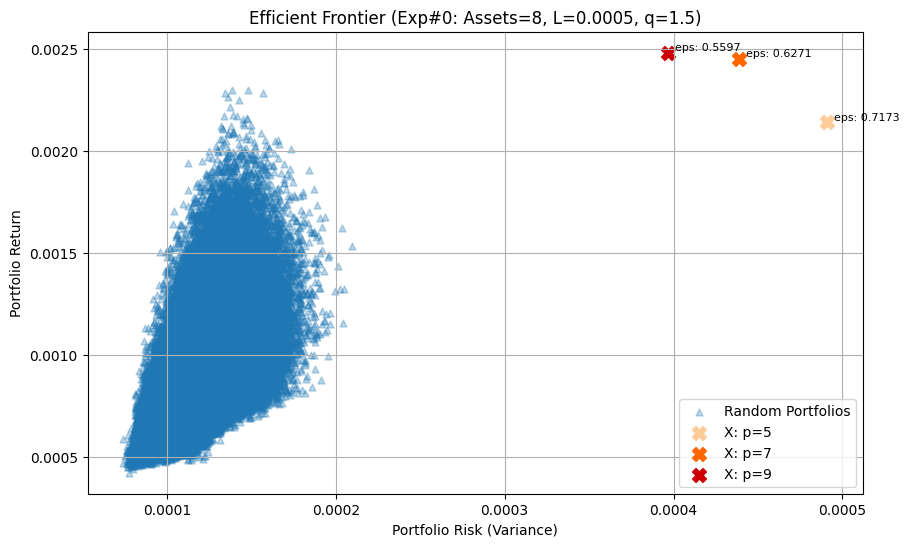

In [8]:
ret_list, cov_list = [],[]
for i in range(150000):
    buy = np.random.dirichlet(np.ones(len(P)))

    ret_list.append(ret.T @ buy)
    cov_list.append(buy.T @ cov @ buy)
ret_list = np.array(ret_list).flatten()
cov_list = np.array(cov_list).flatten()

# P: green, X: red

plt.figure(figsize=(10,6))
# Triangle
plt.scatter(np.array(cov_list), np.array(ret_list), s=25, alpha=0.3, label='Random Portfolios', marker='^')
# plt.scatter(risk_final, ret_final, color='red', s=100, label='Optimized Portfolio', marker='X')
# plt.colorbar(label='Portfolio Price')
for point in points_optim:
    risk, ret_final, mode, layer, is_GA, violation = point
    color_map = color_P if mode.startswith("Preserving") else color_X
    color = color_map[layer]
    marker = 'X' if is_GA else 'X'
    plt.scatter(risk, ret_final, color=color, s=100, label=f'{mode}{("_GA" if is_GA else "_BF") if mode != "X" else ""}: p={layer}', marker=marker)
    # text annotation for violation
    plt.text(risk, ret_final, f'  eps: {violation:.4f}', verticalalignment='bottom', horizontalalignment='left', fontsize=8)
plt.legend()
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Portfolio Return')
plt.title(f'Efficient Frontier (Exp#{exp_idx}: Assets={N_ASSETS}, L={L}, q={q})')
plt.grid(True)
plt.show()

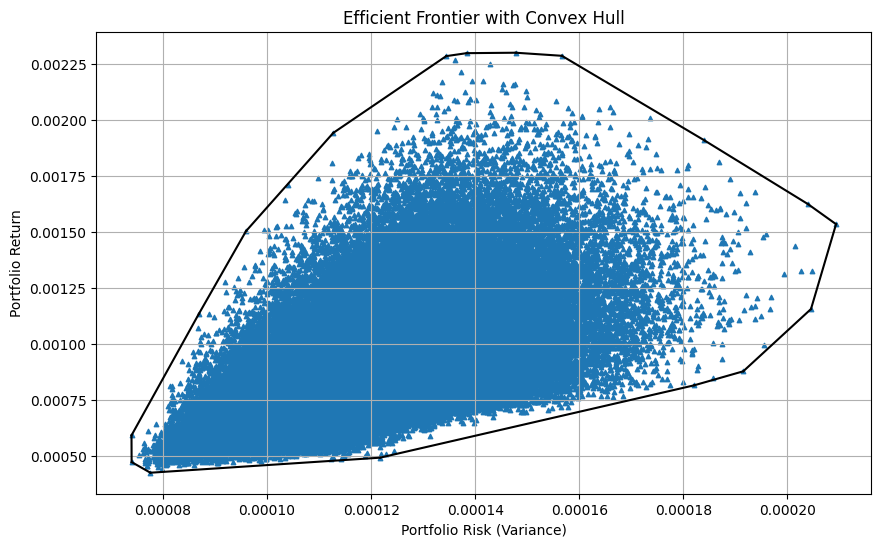

In [9]:
# convex hull
from scipy.spatial import ConvexHull
points = np.array(list(zip(cov_list, ret_list)))
hull = ConvexHull(points)
plt.figure(figsize=(10,6))
plt.scatter(points[:,0], points[:,1], s=10, label='Random Portfolios', marker='^')

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier with Convex Hull')
plt.grid(True)
plt.show()

In [6]:
def find_portfolio_for_risk(mu, cov, target_variance, is_upper_bound=True, options={}):
    n_assets = len(mu)
    def objective_function(weights):
        return (mu.T @ weights) * (-1 if is_upper_bound else 1)
    
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: weights.T @ cov @ weights - target_variance}
    )
    bounds = tuple((0, 1) for _ in range(n_assets))
    # initial_weights = np.ones(n_assets) / n_assets
    initial_weights = np.random.rand(n_assets)

    result = minimize(
        fun=objective_function,
        x0=initial_weights,
        method='COBYLA',
        bounds=bounds,
        constraints=constraints,
        options=options
    )

    return result

def find_bound_var_portfolio(cov, is_min=True):
    n_assets = len(cov)
    def objective(weights):
        return (weights.T @ cov @ weights) * (1 if is_min else -1)
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))
    initial_weights = np.random.rand(n_assets)

    result = minimize(objective, initial_weights, method='COBYLA', bounds=bounds, constraints=constraints, options={'maxiter': 10000, 'disp': 0})
    gmv_weights = result.x
    gmv_return = gmv_weights.T @ ret
    gmv_variance = gmv_weights.T @ cov @ gmv_weights
    return gmv_return, gmv_variance

In [7]:
min_var_return, min_var_value  = find_bound_var_portfolio(cov, is_min=True)
max_var_return, max_var_value = find_bound_var_portfolio(cov, is_min=False)

print(f"Minimum Variance Portfolio: Return = {min_var_return:.6f}, Variance = {min_var_value:.6f}")
print(f"Maximum Variance Portfolio: Return = {max_var_return:.6f}, Variance = {max_var_value:.6f}")

Minimum Variance Portfolio: Return = 0.000532, Variance = 0.000063
Maximum Variance Portfolio: Return = 0.000946, Variance = 0.000127


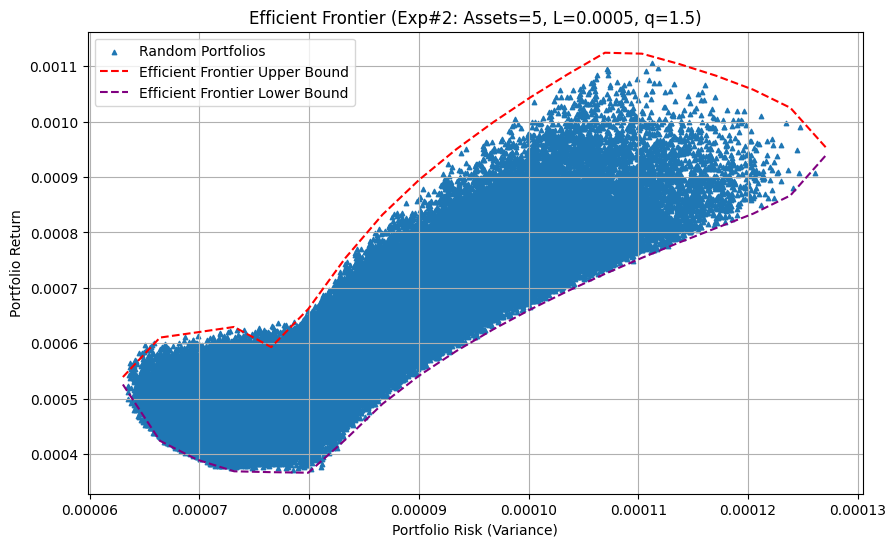

In [10]:
risk_intervals = np.linspace(min_var_value, max_var_value, 20)
# print(risk_intervals)
efficient_frontier_upper, efficient_frontier_lower = [], []
cou = 0
for target_risk in risk_intervals:
    cou += 1
    # optimal_portfolio_upper = find_portfolio_for_risk(ret, cov, target_risk, True, options=({'disp': 1} if cou in [3, 4, 5] else {}))
    optimal_portfolio_upper = find_portfolio_for_risk(ret, cov, target_risk, True)
    optimal_portfolio_lower = find_portfolio_for_risk(ret, cov, target_risk, False)
    if optimal_portfolio_upper.success:
        portfolio_return_upper = -optimal_portfolio_upper.fun
        efficient_frontier_upper.append((target_risk, portfolio_return_upper))
    if optimal_portfolio_lower.success:
        portfolio_return_lower = optimal_portfolio_lower.fun
        efficient_frontier_lower.append((target_risk, portfolio_return_lower))
    # else:
        # print(f"Optimization failed for target risk: {target_risk}") 

plt.figure(figsize=(10,6))
plt.scatter(points[:,0], points[:,1], s=10, label='Random Portfolios', marker='^')

# for point in points_optim:
#     risk, ret_final, mode, layer, is_GA = point
#     color_map = color_P if mode.startswith("Preserving") else color_X
#     color = color_map[layer]
#     marker = 'X' if is_GA else 'X'
#     plt.scatter(risk, ret_final, color=color, s=100, label=f'{mode}{("_GA" if is_GA else "_BF") if mode != "X" else ""}: p={layer}', marker=marker)

efficient_frontier_upper = np.array(efficient_frontier_upper)
efficient_frontier_lower = np.array(efficient_frontier_lower)
plt.plot(efficient_frontier_upper[:,0], efficient_frontier_upper[:,1], 'r--', label='Efficient Frontier Upper Bound')
plt.plot(efficient_frontier_lower[:,0], efficient_frontier_lower[:,1], '--', color='purple', label='Efficient Frontier Lower Bound')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Portfolio Return')
plt.title(f'Efficient Frontier (Exp#{exp_idx}: Assets={N_ASSETS}, L={L}, q={q})')
plt.grid(True)
plt.legend()
plt.show()

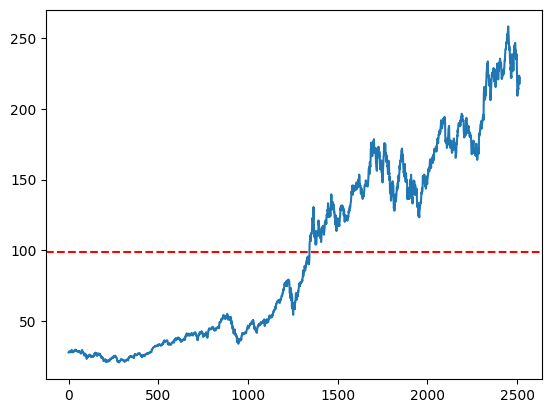

In [9]:
data_ret_p_pd = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_with_returns.csv")
# print(data_ret_p_pd.tail())
# select only 2015 - 2025
AAPL_price = data_ret_p_pd[(data_ret_p_pd['Ticker'] == 'AAPL') & (data_ret_p_pd['Date'] >= '2015-04-01') & (data_ret_p_pd['Date'] <= '2025-04-01')]['Close'].values
plt.plot(AAPL_price)
plt.axhline(y=np.mean(AAPL_price), color='r', linestyle='--', label='Mean Price')